In [1]:
import sys
sys.path.append("../src")
sys.path.append("../exp")

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scienceplots

import benchmark

from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
def figsize(scale):
    fig_width_pt = 469.755                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size
def set_style(paper=False):
    #plt.style.use(['seaborn-white', 'seaborn-paper'])
    if paper:
        plt.style.use(['science','ieee','no-latex'])
    else:
        plt.style.use(['seaborn-white', 'seaborn-paper'])
    #matplotlib.rc("font", family="sans-serif")

    
    matplotlib.rc(
    {                      # setup matplotlib to use latex for output
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 30,               # LaTeX default is 10pt font.
    "font.size": 30,
    "legend.fontsize": 30,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 30,
    "ytick.labelsize": 30,
    })

In [3]:
def clean_df(df):
    # renaming
    df['optimize'] = df['optimize'].replace({False: 'LM', True:'OPT'})
    df = df.rename(columns={'method':"Method",'optimize':'Strategy'})

    train_methods = ['Batch train','Disj. train']
    pred_methods = ['Subs. & aggr. (weight)','Subs. & aggr. (hard)','Batch pred.']

    mask = (df.Method == 'optimize')
    df.loc[mask, 'Method'] = 'Batch train'

    mask = (df.Method == 'original')
    df.loc[mask, 'Method'] = 'Batch train'

    mask = (df.Method == 'disjoint')
    df.loc[mask, 'Method'] = 'Disj. train'

    # df_inf
    mask = (df.Method == 'subsample') & (df.voting == 'weight')
    df.loc[mask, 'Method'] = 'Subs. & aggr. (weight)' 

    mask = (df.Method == 'subsample') & (df.voting == 'hard')
    df.loc[mask, 'Method'] = 'Subs. & aggr. (hard)'

    mask = (df.Method == 'batch')
    df.loc[mask, 'Method'] = 'Batch pred.'


    df_train = df[df['Method'].isin(train_methods)]
    df_pred = df[df['Method'].isin(pred_methods)]
    return df, df_train, df_pred

In [4]:
def run_scikit(dataset, depth, n_trees):

    traindata, testdata = dataset.train_test_split(0.2,random_state=100)
    X_train = traindata.df.iloc[:,:-1].values
    y_train = traindata.df.iloc[:,-1].values
    X_test = testdata.df.iloc[:,:-1].values
    y_test = testdata.df.iloc[:,-1].values
    
    cls = ExtraTreesClassifier(max_depth=depth,n_estimators=n_trees)
    cls.fit(X_train, y_train)
    y_pred_test = cls.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    
    return acc_test

# Varying Privacy Loss

In [8]:
# varying privacy loss
datasets = ['Car','Iris','Balance','Adult']
inputfiles = {
    'Car':'temp/car_id1.csv',
    'Iris':'temp/iris_id1.csv',
    'Balance':'temp/balancescale_id4.csv',
    'Adult':'temp/adult_id2.csv'
}
datasets = {
    'Car':benchmark.car_dataset(),
    'Iris':benchmark.iris_dataset(),
    'Balance':benchmark.balancescale_dataset(),
    'Adult':benchmark.adult_dataset(),
}
depths = {'Car':4,
    'Iris':2,
    'Balance':2,
    'Adult':6}
nestimators = {'Car':128,
    'Iris':64,
    'Balance':128,
    'Adult':16}



In [9]:
# varying privacy loss
hue_order = [ 'DP batch train (ours)',
            'DP batch pred. (ours)',
            'DP batch train - LM',
            'DP disj. train - LM'
                    ]
def plot_privacy_loss(outputfile=None):
    fig, ax = plt.subplots(figsize=(8.5,2), dpi=600,ncols=len(datasets))
    for i, dataname in enumerate(datasets):
        df = pd.read_csv(inputfiles[dataname])
        df,df_train,df_pred = clean_df(df)
        df = df[(df['depth'] == depths[dataname]) & (df['n_estimators'] == nestimators[dataname])]
        df['Dataset'] = [dataname]*df.shape[0]
        
        df_result = pd.concat([df])

        mask = (df_result.Method == 'Batch train') & (df_result.Strategy == 'OPT')
        df_result.loc[mask, 'Method'] = 'DP batch train (ours)'

        mask = (df_result.Method == 'Batch pred.') & (df_result.Strategy == 'OPT')
        df_result.loc[mask, 'Method'] = 'DP batch pred. (ours)'

        mask = (df_result.Method == 'Batch train') & (df_result.Strategy == 'LM')
        df_result.loc[mask, 'Method'] = 'DP batch train - LM'

        mask = (df_result.Method == 'Disj. train') & (df_result.Strategy == 'LM')
        df_result.loc[mask, 'Method'] = 'DP disj. train - LM'

        df_result = df_result[df_result.Method.isin(hue_order)]
        
        g = sns.lineplot(data=df_result, x='eps',y='acc',hue='Method',style='Method',hue_order=hue_order,markers=True,ax=ax[i])
        g.legend_.set_title(None)
        if i != len(datasets)-1:
            ax[i].get_legend().remove()
        non_private_acc = run_scikit(datasets[dataname],None,nestimators[dataname])
        print(non_private_acc)
        ax[i].axhline(y=non_private_acc,label='Non-private',color='grey')
        ax[i].set_xlabel('Privacy loss $\\epsilon$')
        ax[i].set_ylabel('Accuracy')
        ax[i].set_title(dataname)
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    #ax.autoscale(tight=True)
    plt.legend()
    fig.tight_layout()
    fig.savefig('figures/eps_vs_accuracy.jpg', dpi=600)
    
    plt.show()


0.9739884393063584
0.9666666666666667
0.848
0.817910447761194


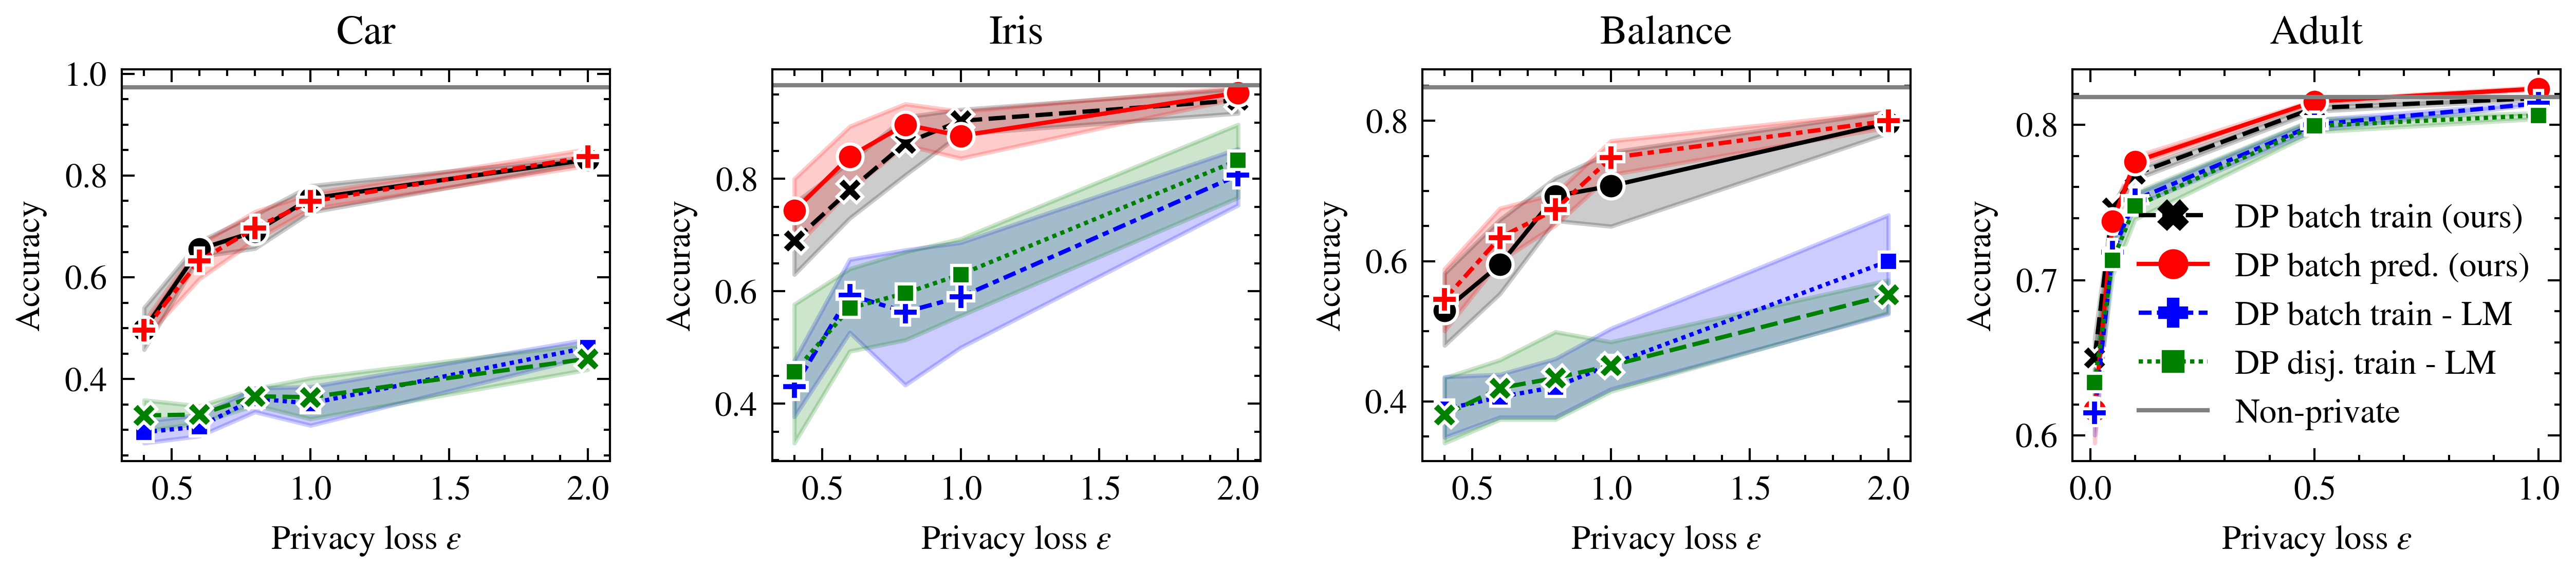

In [11]:
set_style(paper=True)
plot_privacy_loss()

In [12]:
# varying a number of trees

dataname = 'Car'
eps = 2.0

hue_order = [ 'DP batch train (ours)',
            'DP batch train - LM',
            'DP disj. train - LM'
                    ]
def plot_nesnsembles(outputfile=None):
        fig, ax = plt.subplots(figsize=(2.5,1.8), dpi=600)
        df = pd.read_csv(inputfiles[dataname])
        df,df_train,df_pred = clean_df(df)
        df_result = df[(df['depth'] == depths[dataname]) & (df['eps'] == eps)]

        mask = (df_result.Method == 'Batch train') & (df_result.Strategy == 'OPT')
        df_result.loc[mask, 'Method'] = 'DP batch train (ours)'

        mask = (df_result.Method == 'Batch train') & (df_result.Strategy == 'LM')
        df_result.loc[mask, 'Method'] = 'DP batch train - LM'

        mask = (df_result.Method == 'Disj. train') & (df_result.Strategy == 'LM')
        df_result.loc[mask, 'Method'] = 'DP disj. train - LM'

        df_result = df_result[df_result.Method.isin(hue_order)]

        g = sns.lineplot(data=df_result, x='n_estimators',y='acc',hue='Method',style='Method',hue_order=hue_order,markers=True)
        g.legend_.set_title(None)
        ntrees = df_result['n_estimators'].unique()
        acc = extra_trees_nensembles(ntrees)
        print(acc)
        ax.plot(ntrees,acc,label='Non-private',color='grey',linestyle='-')
        ax.set_xlabel('Number of trees')
        ax.set_ylabel('Accuracy')
        plt.legend()
        fig.tight_layout()
        fig.savefig('figures/car_dptrain_nestimators.jpg', dpi=600)
        
        plt.show()

def extra_trees_nensembles(ntrees=[1,4,8,16,32,64,128]):
        accuracy_score=[]
        for t in ntrees:
                accuracy_score.append(run_scikit(datasets[dataname],None,t))
        return accuracy_score


/Users/arisa/miniconda3/envs/oldresearch/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


[0.9075144508670521, 0.9161849710982659, 0.953757225433526, 0.9653179190751445, 0.9710982658959537, 0.9739884393063584, 0.9739884393063584]


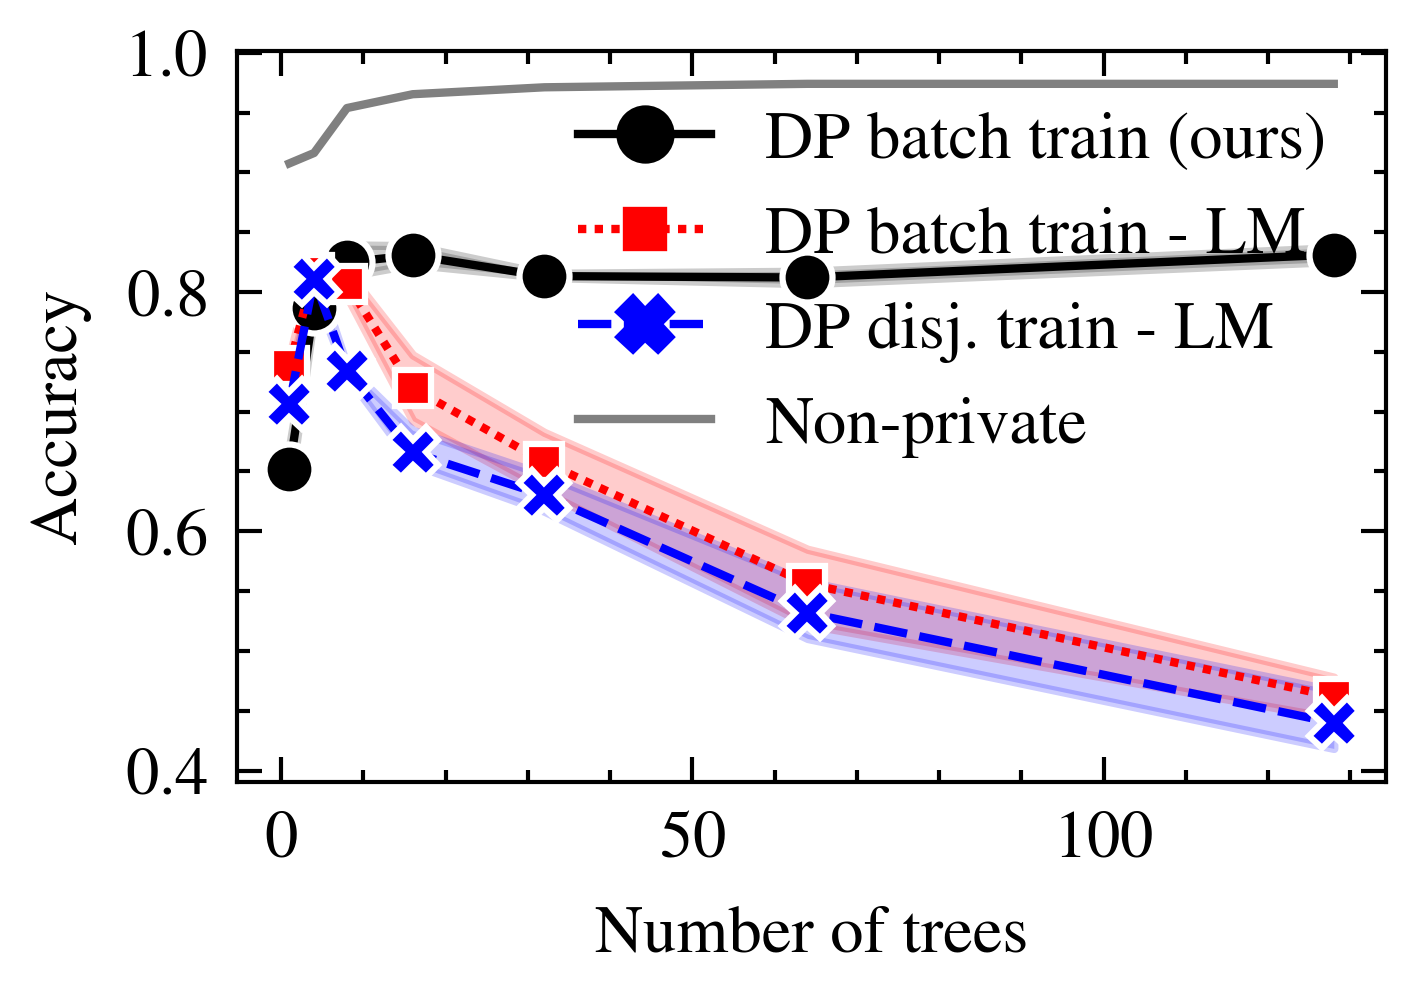

In [13]:
set_style(paper=True)
plot_nesnsembles()

In [17]:
# varying a number of samples

dataname = 'Car'

hue_order = [ 'DP batch pred. (ours)',
            'Subs. & aggr.'
                    ]

def plot_samplesize(outputfile=None):
        fig, ax = plt.subplots(figsize=(2.5,1.8), dpi=600)
        df = pd.read_csv('temp/car_id10.csv') # depth 4 and number of estimators 16. eps=2
        df_result,df_train,df_pred = clean_df(df)
        
        mask = (df_result.Method == 'Batch pred.') & (df_result.Strategy == 'OPT')
        df_result.loc[mask, 'Method'] = 'DP batch pred. (ours)'

        mask = (df_result.Method == 'Subs. & aggr. (weight)') & (df_result.Strategy == 'LM')
        df_result.loc[mask, 'Method'] = 'Subs. & aggr.'

        df_result = df_result[df_result.Method.isin(hue_order)]

        g = sns.lineplot(data=df_result, x='n_samples',y='acc',hue='Method',style='Method',hue_order=hue_order,markers=True)
        nsamples = df_result['n_samples'].unique()
        acc = run_nonprivate(datasets[dataname],None,16,nsamples)
        print(acc)
        ax.plot(nsamples,acc,label='Non-private',color='grey')
        g.legend_.set_title(None)
        ax.set_xlabel('Number of inference queries')
        ax.set_ylabel('Accuracy')
        plt.legend()
        fig.tight_layout()
        fig.savefig('figures/car_dppred_samplesize.jpg', dpi=600)
        plt.show()

def run_nonprivate(dataset, depth, n_trees,ntestsamples):
        traindata = dataset.copy()
        X_train = traindata.df.iloc[:,:-1].values
        y_train = traindata.df.iloc[:,-1].values
        
        cls = ExtraTreesClassifier(max_depth=depth,n_estimators=n_trees)
        cls.fit(X_train, y_train)
        acc = []
        for n in ntestsamples:
                testdata = dataset.sample(n)
                X_test = testdata.df.iloc[:,:-1].values
                y_test = testdata.df.iloc[:,-1].values
                y_pred_test = cls.predict(X_test)
                acc_test = accuracy_score(y_test, y_pred_test)
                acc.append(acc_test)

        return acc

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


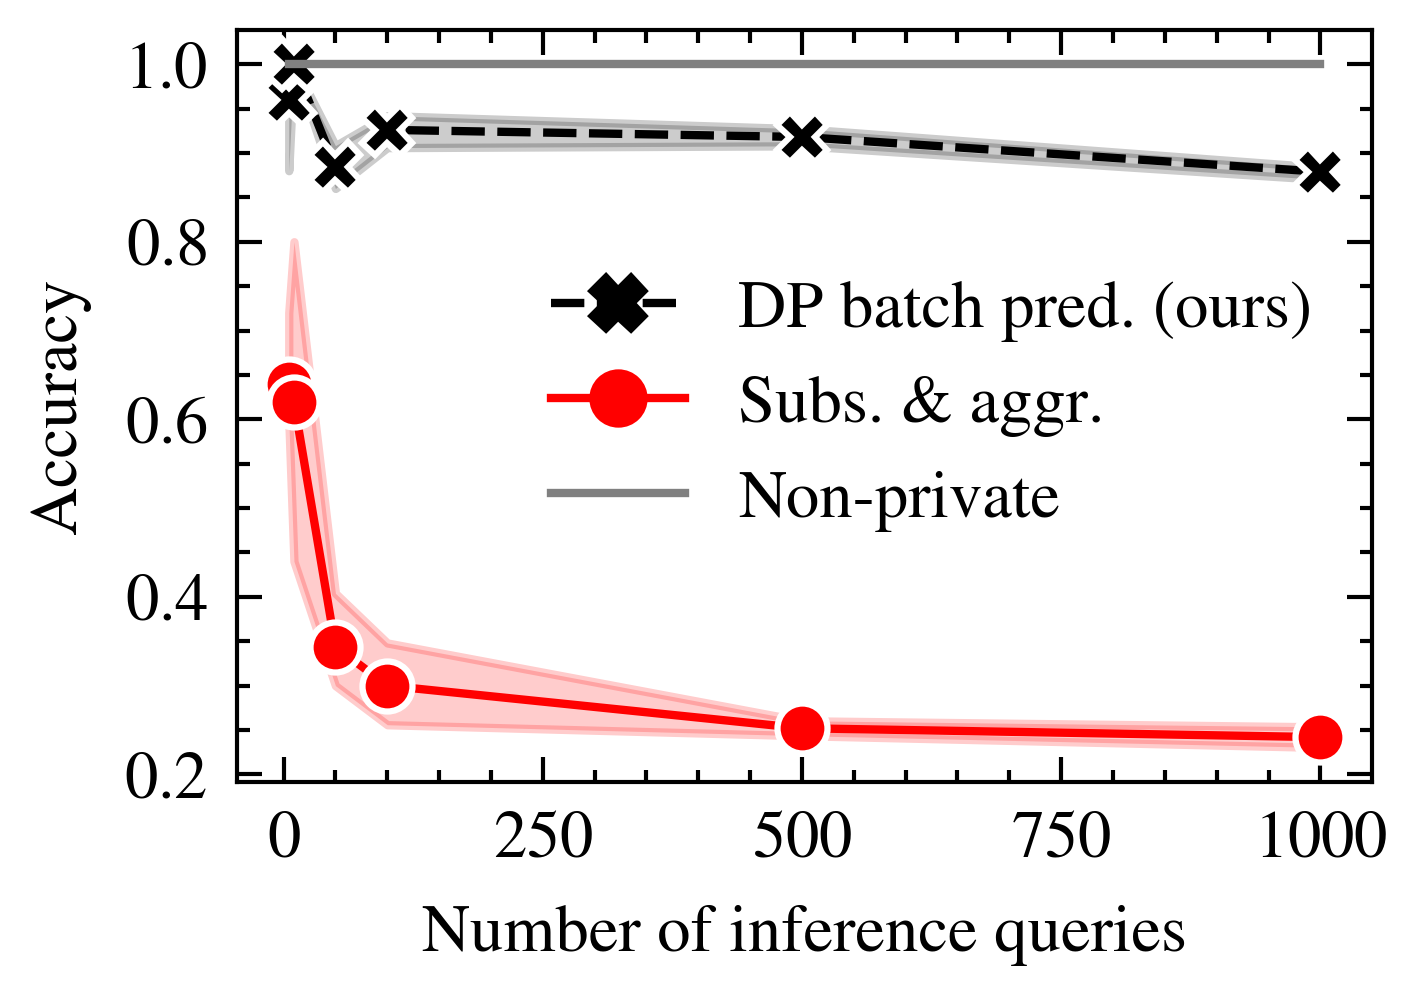

In [18]:
set_style(paper=True)
plot_samplesize()

In [19]:
# subsample and aggregate

dataname = 'Adult'

hue_order = [ 'Subs. & aggr. - OPT (ours)',
            'Subs. & aggr. - LM'
                    ]

def plot_subsample(outputfile=None):
        fig, ax = plt.subplots(figsize=(2.5,1.8), dpi=600)
        df = pd.read_csv('temp/adult_id4.csv') # depth 6 and number of estimators 16
        df_result,df_train,df_pred = clean_df(df)
        
        mask = (df_result.Method == 'Subs. & aggr. (weight)') & (df_result.Strategy == 'OPT')
        df_result.loc[mask, 'Method'] = 'Subs. & aggr. - OPT (ours)'

        mask = (df_result.Method == 'Subs. & aggr. (weight)') & (df_result.Strategy == 'LM')
        df_result.loc[mask, 'Method'] = 'Subs. & aggr. - LM'

        df_result = df_result[df_result.Method.isin(hue_order)]

        g = sns.lineplot(data=df_result, x='eps',y='acc',hue='Method',style='Method',hue_order=hue_order,markers=True)
        g.legend_.set_title(None)
        ax.set_xlabel('Privacy loss $\\epsilon$')
        ax.set_ylabel('Accuracy')
        fig.tight_layout()
        fig.savefig('figures/adult_subsample.jpg', dpi=600)
        plt.show()

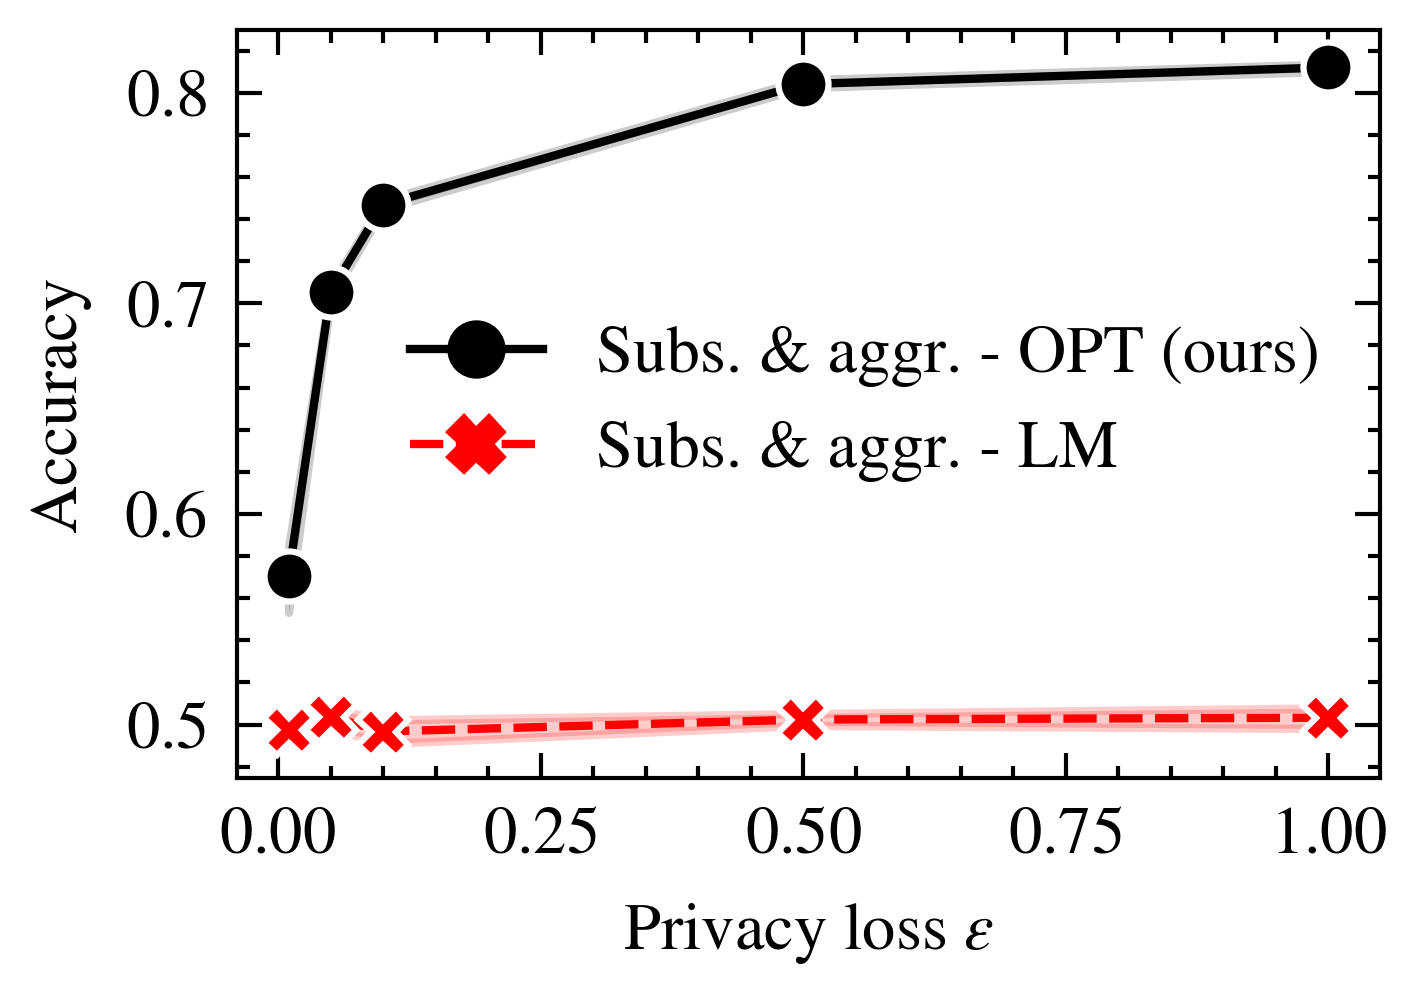

In [20]:
set_style(paper=True)
plot_subsample()

In [21]:
# high dimensional dataset

# varying privacy loss
hue_order = [ 'DP batch train (ours)',
            'DP batch pred. (ours)',
            'DP batch train - LM',
                    ]
def plot_highdimensional(outputfile=None):
    fig, ax = plt.subplots(figsize=(4.8,2), dpi=600,ncols=2)
    inputfiles = {
        'Heart':'temp/heart_nensembles3_2.csv',
        'Mushroom':'temp/mushroom_nensembles5_2.csv',
    }
    datasets = {
        'Heart':benchmark.heart_dataset(),
        'Mushroom':benchmark.mushroom_dataset(),
    }
    nestimators={
        'Heart':100,
        'Mushroom':100,
    }
    for i, dataname in enumerate(['Heart','Mushroom']):
        df = pd.read_csv(inputfiles[dataname])
        df,df_train,df_pred = clean_df(df)
        df['Dataset'] = [dataname]*df.shape[0]
        
        df_result = pd.concat([df])

        mask = (df_result.Method == 'Batch train') & (df_result.Strategy == 'OPT')
        df_result.loc[mask, 'Method'] = 'DP batch train (ours)'

        mask = (df_result.Method == 'Batch pred.') & (df_result.Strategy == 'OPT')
        df_result.loc[mask, 'Method'] = 'DP batch pred. (ours)'

        mask = (df_result.Method == 'Batch train') & (df_result.Strategy == 'LM')
        df_result.loc[mask, 'Method'] = 'DP batch train - LM'


        df_result = df_result[df_result.Method.isin(hue_order)]
        
        g = sns.lineplot(data=df_result, x='eps',y='acc',hue='Method',style='Method',hue_order=hue_order,markers=True,ax=ax[i])
        g.legend_.set_title(None)
        non_private_acc = run_scikit(datasets[dataname],None,nestimators[dataname])
        print(non_private_acc)
        ax[i].axhline(y=non_private_acc,label='Non-private',color='grey')
        if i != len(datasets)-1:
            ax[i].get_legend().remove()
        ax[i].set_xlabel('Privacy loss $\\epsilon$')
        ax[i].set_ylabel('Accuracy')
        ax[i].set_title(dataname)
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    #ax.autoscale(tight=True)
    plt.legend()
    fig.tight_layout()
    fig.savefig('figures/highdimensional.jpg', dpi=600)
    
    plt.show()


0.8333333333333334
1.0


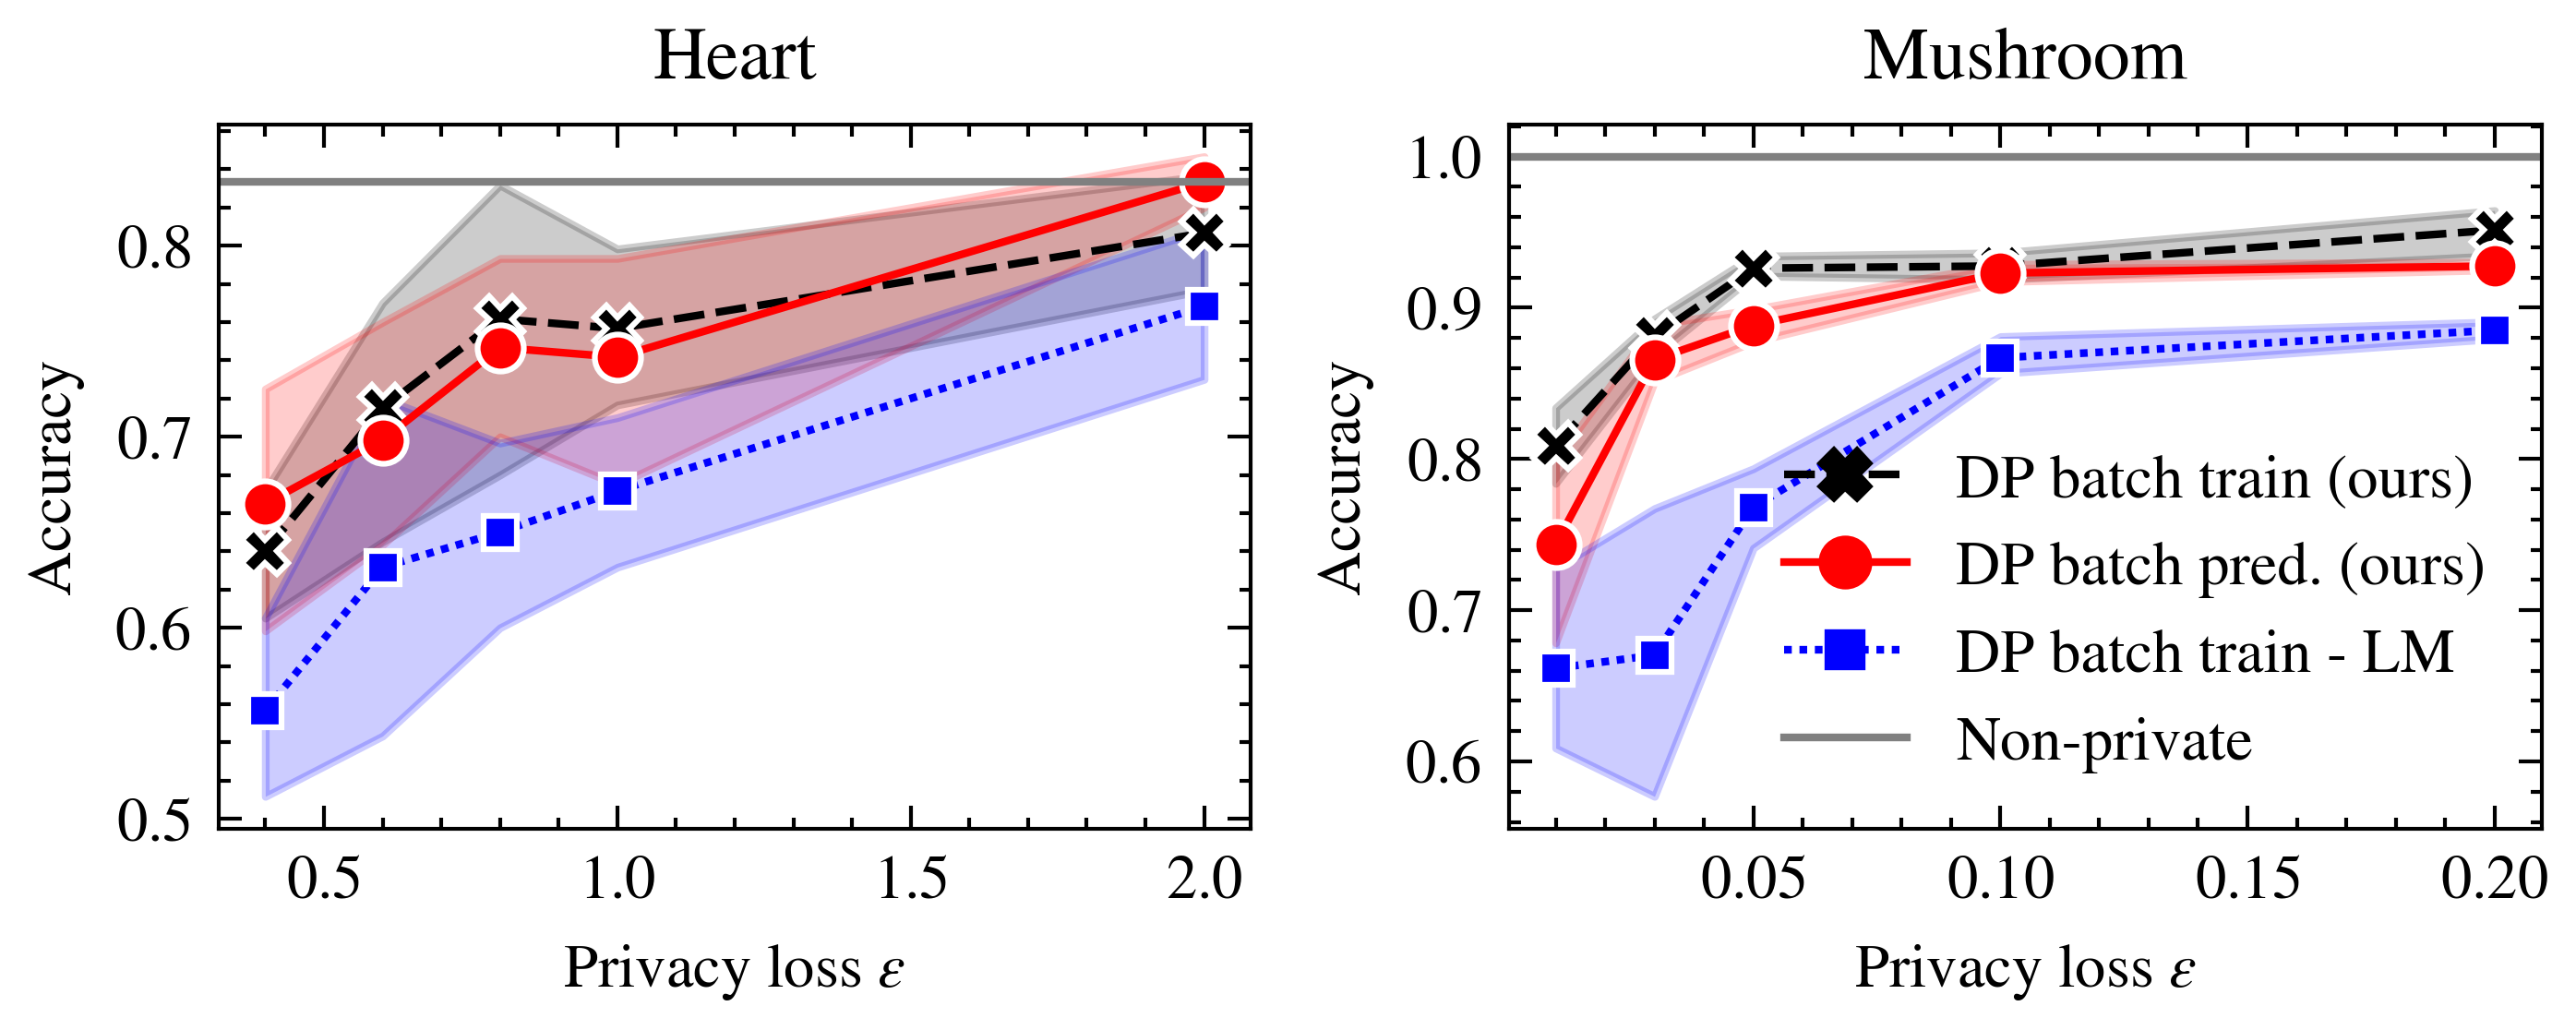

In [22]:
set_style(paper=True)
plot_highdimensional()

In [24]:
# subsample and aggregate


hue_order = [ 'Subs. & aggr. (weight)',
            'Subs. & aggr. (hard)'
                    ]

def plot_subsample_privacy_loss(outputfile=None):
        inputfiles = {
        'Car':'temp/car_id2.csv',
        'Iris':'temp/iris_id2.csv',
        'Balance':'temp/balancescale_id6.csv',
        'Adult':'temp/adult_id4.csv',
        
        }
        depths={
                'Car':3,
                'Iris':2,
                'Balance':2,
                'Adult':6,
        }
        nestimators={
                'Car':16,
                'Iris':16,
                'Balance':16,
                'Adult':16
        }
        fig, ax = plt.subplots(figsize=(11,2), dpi=600,ncols=len(datasets))
        for i, dataname in enumerate(datasets):
                df = pd.read_csv(inputfiles[dataname])
                df,df_train,df_pred = clean_df(df)
                df = df[(df['depth'] == depths[dataname]) & (df['n_estimators'] == nestimators[dataname])]
                df['Dataset'] = [dataname]*df.shape[0]
                
                df_result = pd.concat([df])
                
                df_result.loc[(df_result.Strategy == 'OPT'), 'Strategy'] = 'ours'
                df_result = df_result[df_result.Method.isin(hue_order)]

                g = sns.lineplot(data=df_result, x='eps',y='acc',hue='Method',style='Strategy',hue_order=hue_order,markers=True,ax=ax[i])
                g.legend_.set_title(None)
                
                ax[i].get_legend().remove()
                ax[i].set_xlabel('Privacy loss $\\epsilon$')
                ax[i].set_ylabel('Accuracy')
                ax[i].set_title(dataname)
                ax[0].legend(loc='lower right', bbox_to_anchor=(0.8,-0.32), ncol=2, bbox_transform=fig.transFigure)
        fig.tight_layout()
        fig.savefig('figures/subsample_eps.jpg', dpi=600)
        plt.show()

/Users/arisa/miniconda3/envs/oldresearch/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


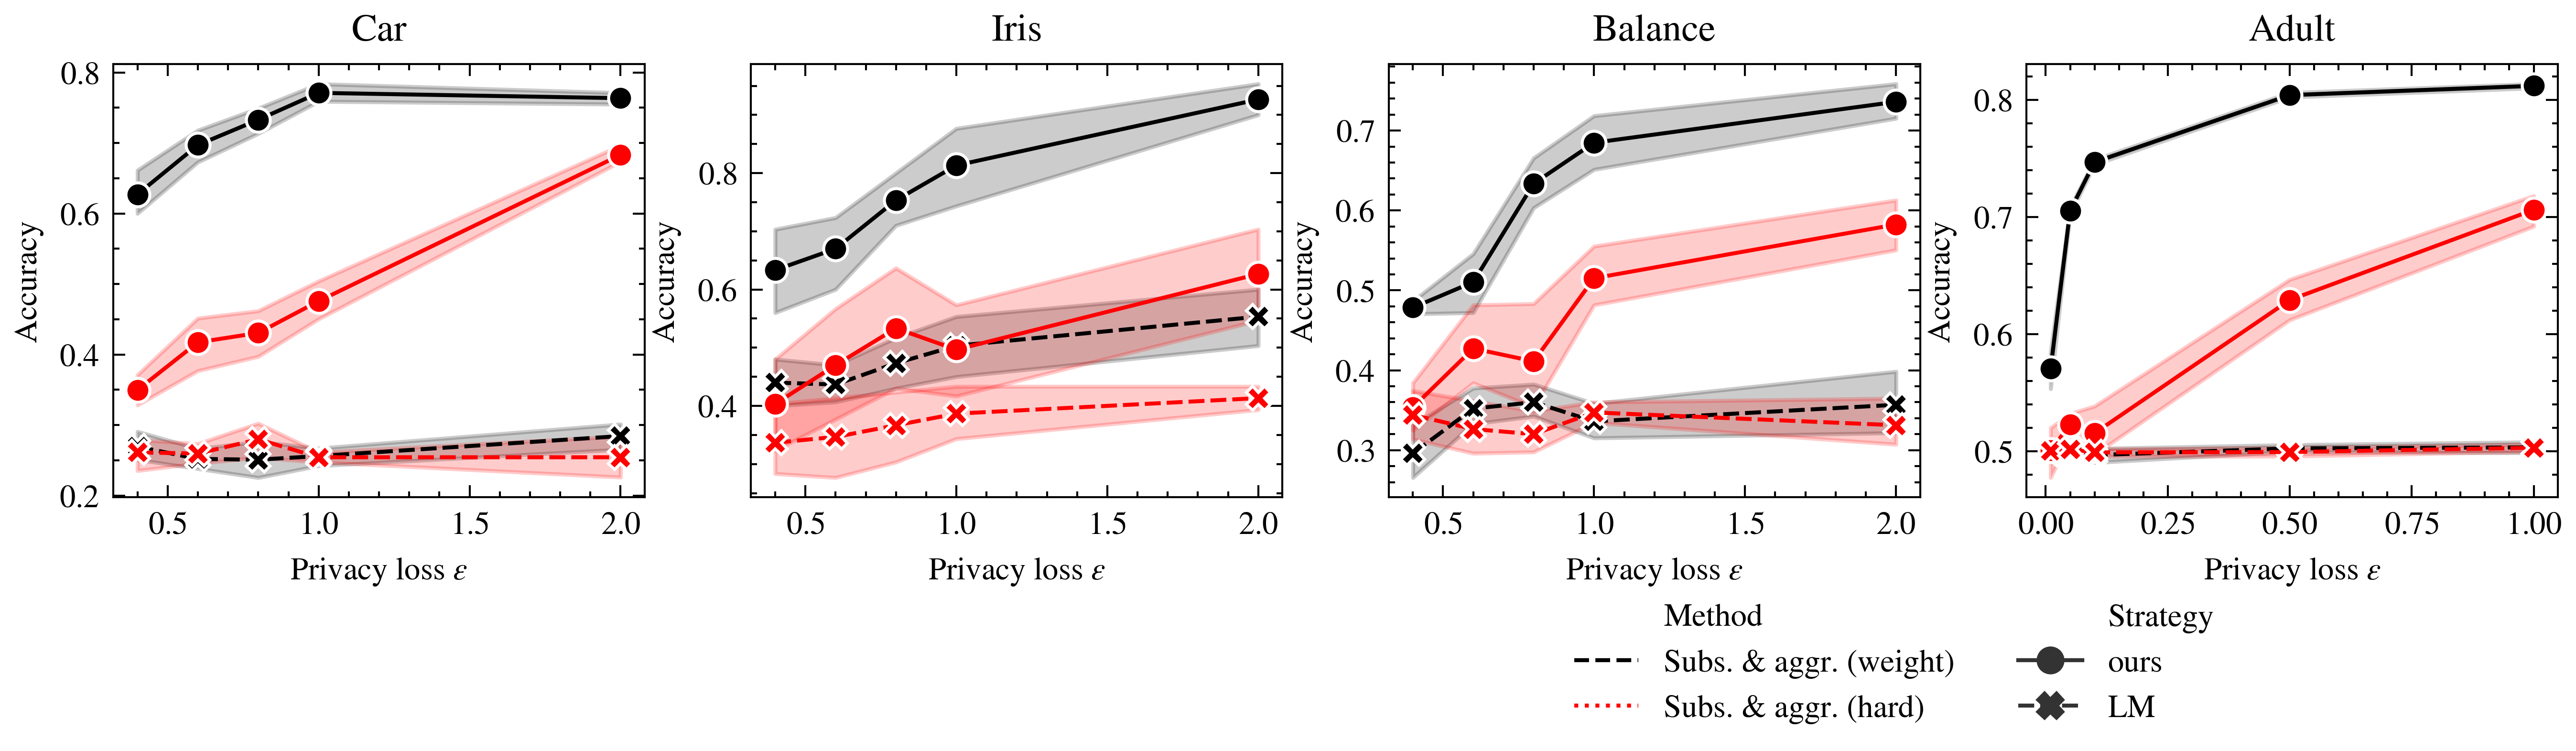

In [25]:
set_style(paper=True)
plot_subsample_privacy_loss()

In [26]:
# subsample and aggregate varying a number of trees

dataname = 'Car'
eps = 2.0

hue_order = [ 'Subs. & aggr. (weight)',
            'Subs. & aggr. (hard)'
                    ]
def plot_subsample_nesnsembles(outputfile=None):
        fig, ax = plt.subplots(figsize=(2.5,1.8), dpi=600)
        df = pd.read_csv('temp/car_id2.csv')
        df,df_train,df_pred = clean_df(df)
        df_result = df[(df['depth'] == 3) & (df['eps'] == eps) & (df['Strategy']=='OPT')]

        df_result = df_result[df_result.Method.isin(hue_order)]

        g = sns.lineplot(data=df_result, x='n_estimators',y='acc',hue='Method',style='Method',hue_order=hue_order,markers=True)
        g.legend_.set_title(None)
        ax.set_xlabel('Number of trees')
        ax.set_ylabel('Accuracy')
        fig.tight_layout()
        fig.savefig('figures/car_subsample_nestimators.jpg', dpi=600)
        
        plt.show()


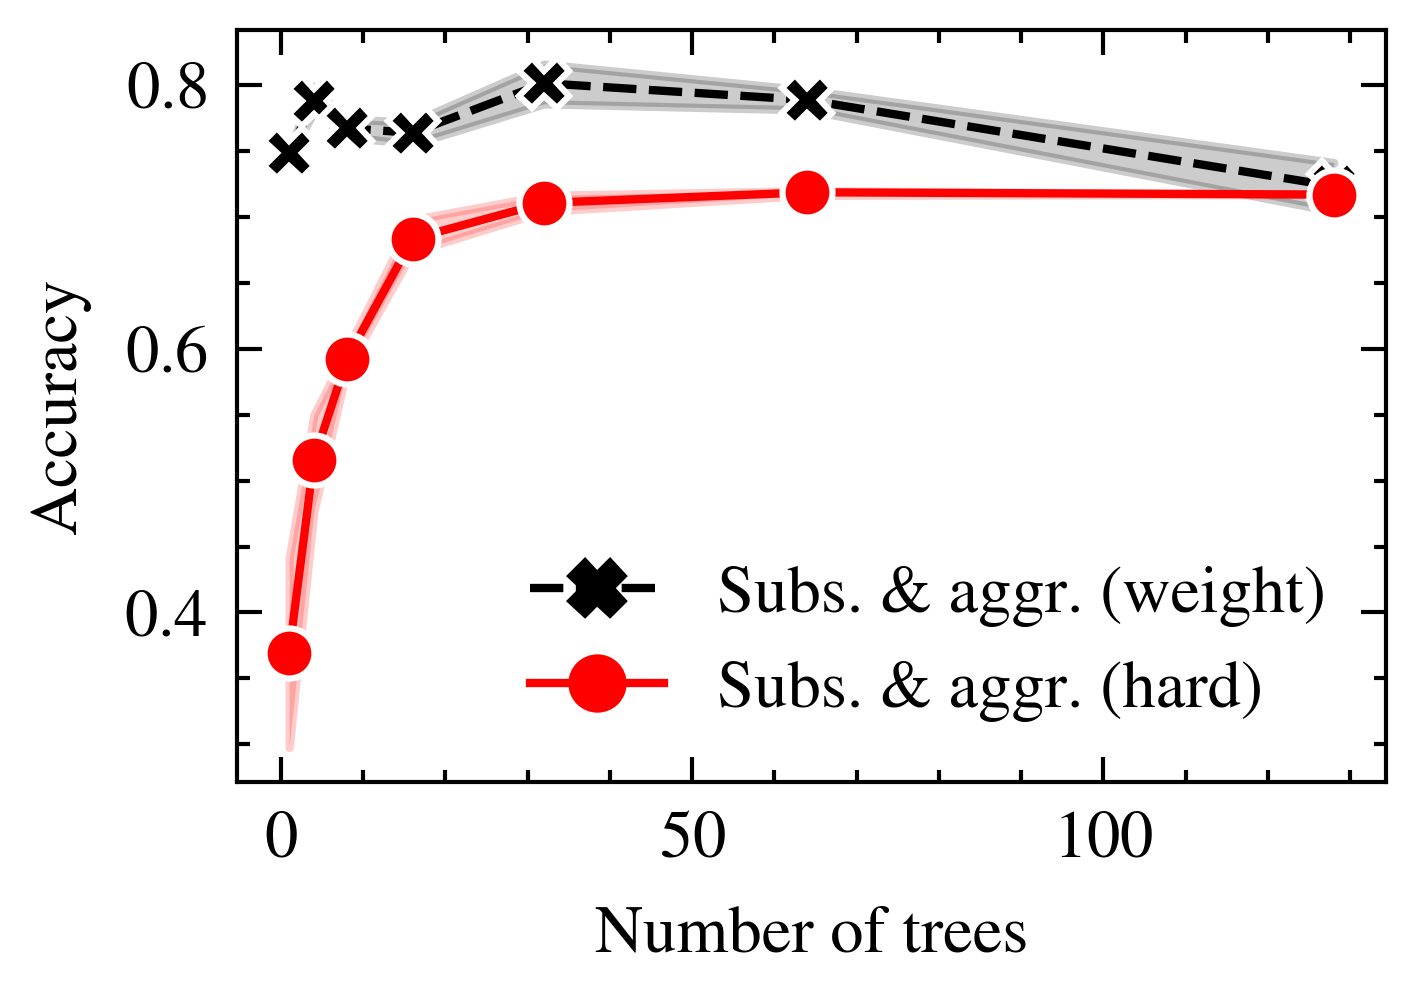

In [27]:
set_style(paper=True)
plot_subsample_nesnsembles()

In [28]:
# subsample and aggregate varying a number of depths

dataname = 'Car'
eps = 2.0

hue_order = [ 'Subs. & aggr. (weight)',
            'Subs. & aggr. (hard)'
                    ]
def plot_subsample_depth(outputfile=None):
        fig, ax = plt.subplots(figsize=(2.5,1.8), dpi=600)
        df = pd.read_csv('temp/car_id2.csv')
        df,df_train,df_pred = clean_df(df)
        df_result = df[(df['n_estimators'] == 16) & (df['eps'] == eps) & (df['Strategy']=='OPT')]

        df_result = df_result[df_result.Method.isin(hue_order)]

        g = sns.lineplot(data=df_result, x='depth',y='acc',hue='Method',style='Method',hue_order=hue_order,markers=True)
        g.legend_.set_title(None)
        ax.set_xlabel('Depth')
        ax.set_ylabel('Accuracy')
        fig.tight_layout()
        fig.savefig('figures/car_subsample_depth.jpg', dpi=600)
        
        plt.show()

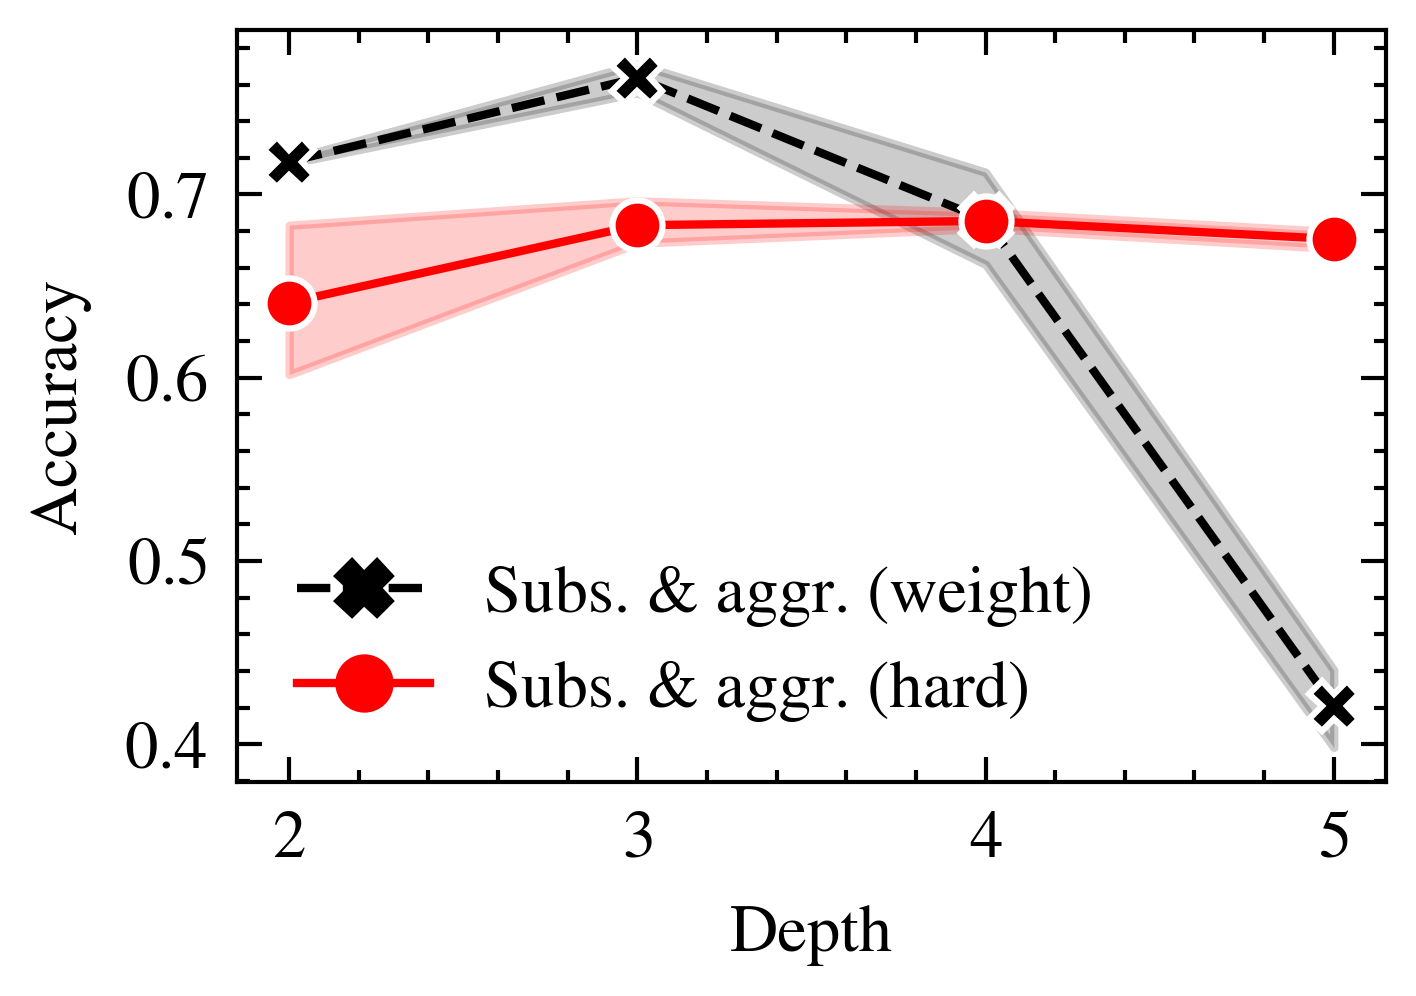

In [29]:
set_style(paper=True)
plot_subsample_depth()

In [30]:
# varying a number of samples

dataname = 'Car'

hue_order = [ 'Subs. & aggr. (weight)',
            'Subs. & aggr. (hard)'
                    ]

def plot_subsample_samplesize(outputfile=None):
        fig, ax = plt.subplots(figsize=(3,2), dpi=600)
        df = pd.read_csv('temp/car_id10.csv') # depth 4 and number of estimators 16. eps=2
        df_result,df_train,df_pred = clean_df(df)
        
        df_result.loc[(df_result.Strategy == 'OPT'), 'Strategy'] = 'ours'
        
        df_result = df_result[df_result.Method.isin(hue_order)]

        g = sns.lineplot(data=df_result, x='n_samples',y='acc',hue='Method',style='Strategy',hue_order=hue_order,markers=True)
        g.legend_.set_title(None)
        ax.legend(loc='lower right', bbox_to_anchor=(1,-0.2), ncol=2, bbox_transform=fig.transFigure)
        ax.set_xlabel('Number of inference queries')
        ax.set_ylabel('Accuracy')
        
        fig.tight_layout()
        fig.savefig('figures/car_subsampled_samplesize.jpg', dpi=600)
        plt.show()

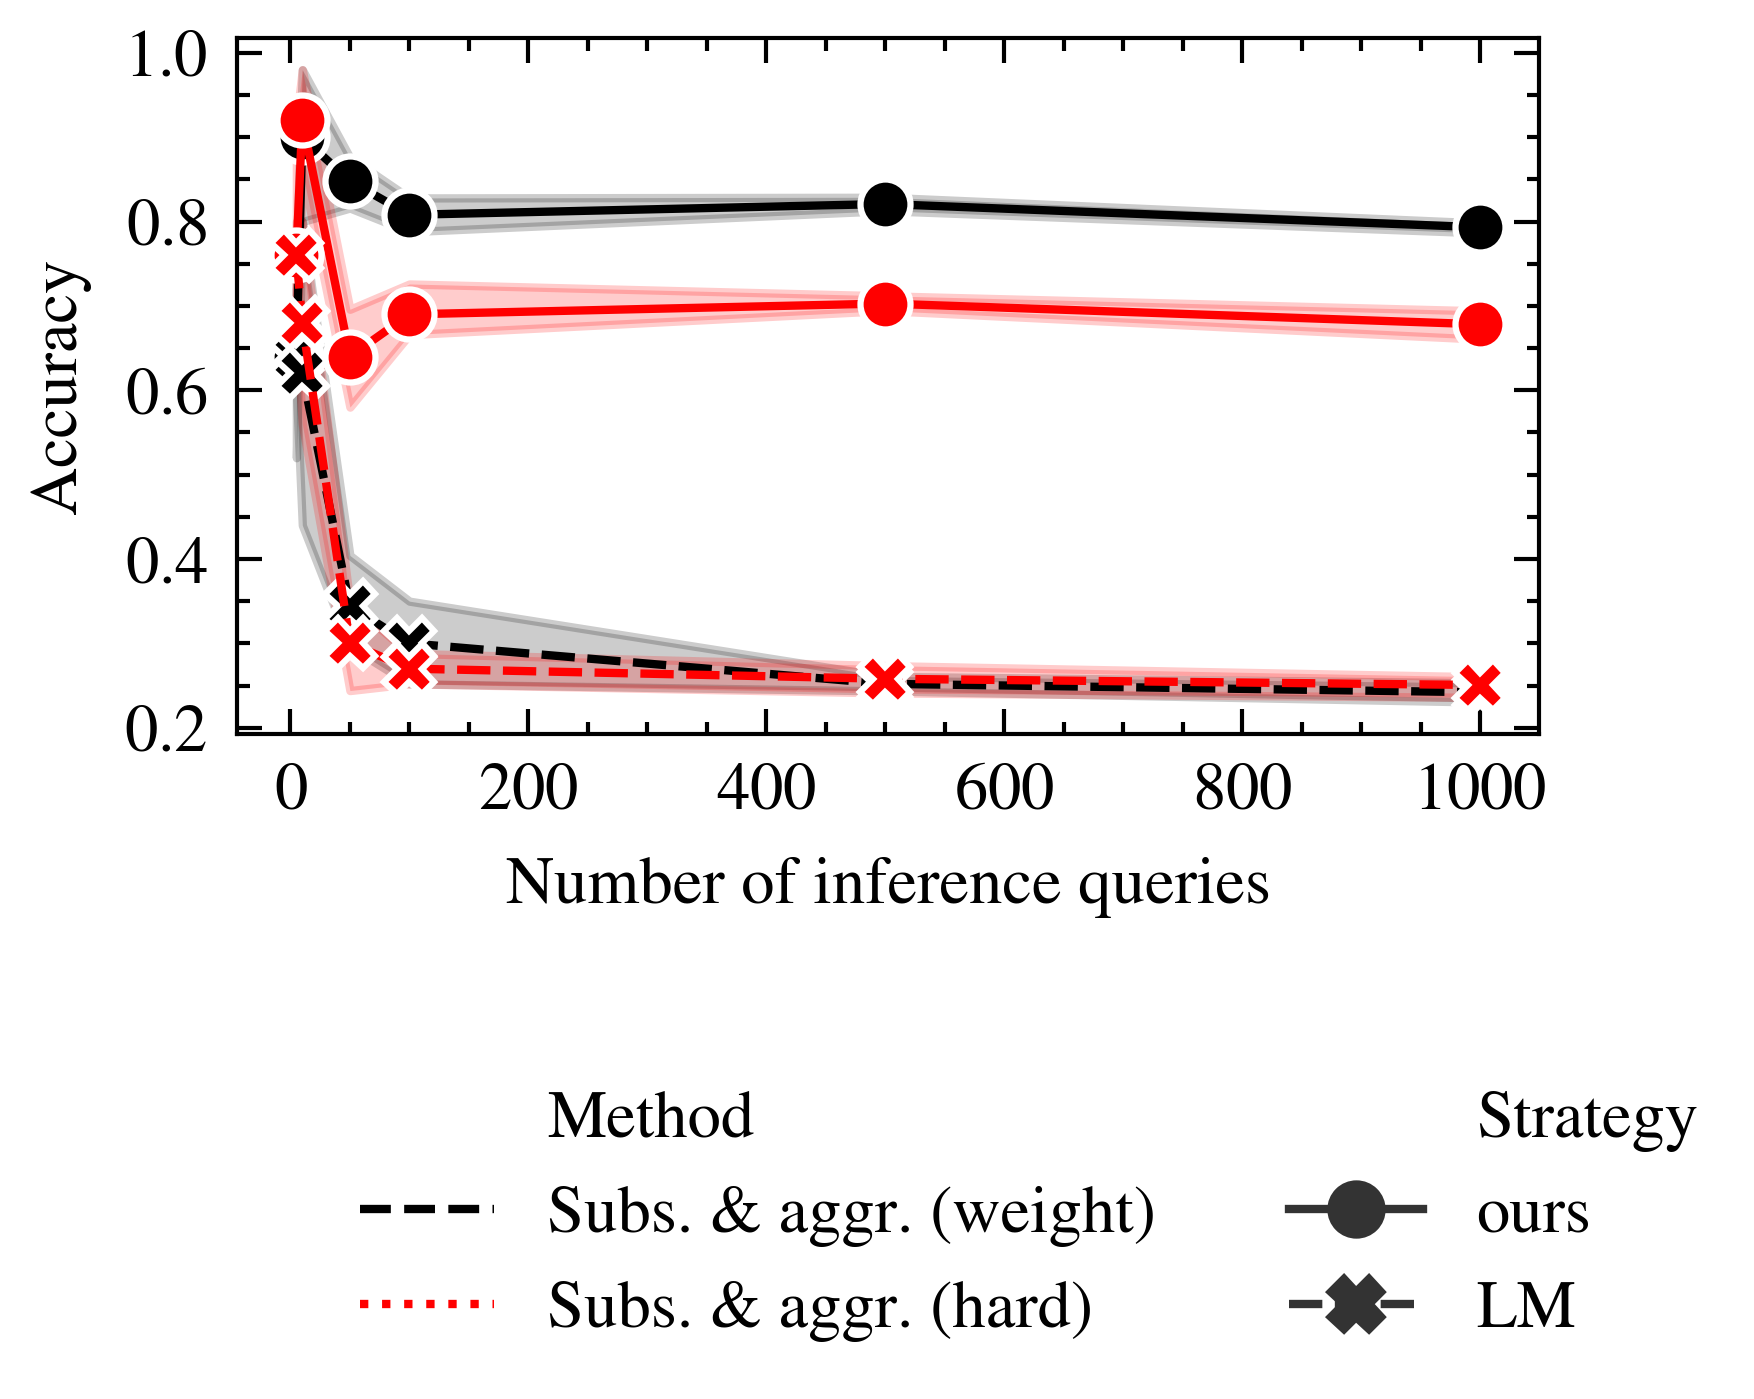

In [31]:
set_style(paper=True)
plot_subsample_samplesize()

In [32]:
# private prediction varying a number of depths

dataname = 'Car'
eps = 2.0

hue_order = [ 'DP batch train (ours)',
            'DP batch pred. (ours)',
            'DP batch train - LM',
            'DP disj. train - LM'
                    ]
def plot_car_depth(outputfile=None):
        fig, ax = plt.subplots(figsize=(2.5,1.8), dpi=600)
        df = pd.read_csv('temp/car_id1.csv')
        df,df_train,df_pred = clean_df(df)
        df_result = df[(df['n_estimators'] == 128) & (df['eps'] == eps)]

        mask = (df_result.Method == 'Batch train') & (df_result.Strategy == 'OPT')
        df_result.loc[mask, 'Method'] = 'DP batch train (ours)'

        mask = (df_result.Method == 'Batch pred.') & (df_result.Strategy == 'OPT')
        df_result.loc[mask, 'Method'] = 'DP batch pred. (ours)'

        mask = (df_result.Method == 'Batch train') & (df_result.Strategy == 'LM')
        df_result.loc[mask, 'Method'] = 'DP batch train - LM'

        mask = (df_result.Method == 'Disj. train') & (df_result.Strategy == 'LM')
        df_result.loc[mask, 'Method'] = 'DP disj. train - LM'

        df_result = df_result[df_result.Method.isin(hue_order)]

        g = sns.lineplot(data=df_result, x='depth',y='acc',hue='Method',style='Method',hue_order=hue_order,markers=True)
        g.legend_.set_title(None)
        ax.set_xlabel('Depth')
        ax.set_ylabel('Accuracy')
        fig.tight_layout()
        fig.savefig('figures/car_depth.jpg', dpi=600)
        
        plt.show()

/Users/arisa/miniconda3/envs/oldresearch/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


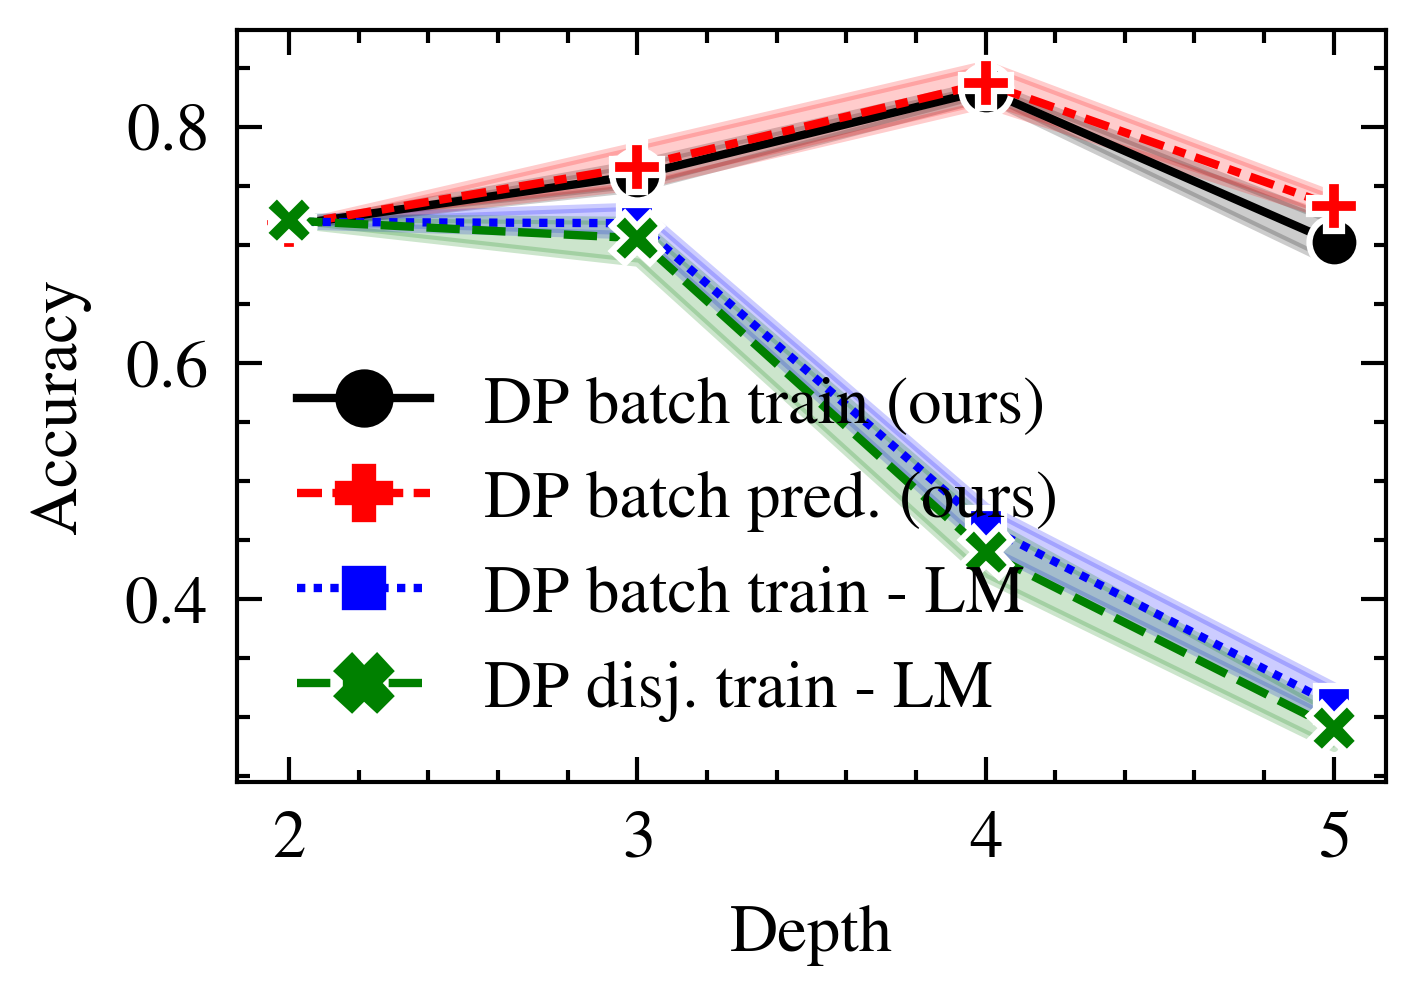

In [33]:
set_style(paper=True)
plot_car_depth()